# The problem of "Predicting Oil Prices."

✨ **This project aims to predict the future price of oil**, specifically focusing on the Brent crude oil. 

🎯 **Accurate price prediction is crucial for various stakeholders**, particularly in the context of Iran's oil pricing.

📉 **By utilizing real data and implementing predictive models**, this project seeks to provide valuable insights into the future trends and fluctuations in oil prices.


## Importing necessary libraries : 

In [28]:
import numpy as np
import pandas as pd
from PyEMD import EMD
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [29]:
## check missing in pandas
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print (f"Your selected dataframe has {df.shape[1]} columns.\n"      
            f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values.")
        return mis_val_table_ren_columns

## Dataset
Each row in this dataset contains information about the prices traded on a particular day. The columns of this dataset are:

| Feature | Description |
| :- | :- |
|Date   |  date related to the information of a row
|Price   | average price traded in a day
|Open  | starting price in one day
|High   |  The highest price traded in a day
| Low  |  The lowest traded price in a day
| Vol.   | the volume of trades made per day
| Change % | percentage of price change compared to the previous date (previous week)

After loading the dataset, we change the type of each column appropriately. For example, the date column must be of date type. We also, handle rows and columns without values appropriately (dropping is not necessarily a logical solution in this case).
Then we draw a time series graph for each column.

## Step1 : loading the dataset and preprocessing

In [30]:
df = pd.read_csv('brent_oil_weekly_30_years.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,4/9/2023,84.46,85.23,85.52,84.11,NaN,-0.78%
1,4/2/2023,85.12,86.00,86.44,83.50,1.29M,6.55%
2,3/26/2023,79.89,74.62,79.95,74.39,1.68M,6.53%
3,3/19/2023,74.99,73.01,77.44,70.12,1.06M,2.77%
4,3/12/2023,72.97,82.60,83.48,71.40,2.13M,-11.85%


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1566 non-null   object 
 1   Price     1566 non-null   float64
 2   Open      1566 non-null   float64
 3   High      1566 non-null   float64
 4   Low       1566 non-null   float64
 5   Vol.      1565 non-null   object 
 6   Change %  1566 non-null   object 
dtypes: float64(4), object(3)
memory usage: 85.8+ KB


In [32]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Replace empty strings with NaN and Convert 'Vol.' column to numeric type
df['Vol.'] = df['Vol.'].replace('', np.nan)
df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').astype(float)

# Remove '%' symbol and convert 'Change %' column to float
df['Change %'] = df['Change %'].str.rstrip('%').astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1566 non-null   datetime64[ns]
 1   Price     1566 non-null   float64       
 2   Open      1566 non-null   float64       
 3   High      1566 non-null   float64       
 4   Low       1566 non-null   float64       
 5   Vol.      1565 non-null   float64       
 6   Change %  1566 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 85.8 KB


In [33]:
missing_values_table(df)

Your selected dataframe has 7 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Vol.,1,0.1


In [34]:
df['Vol.'].fillna(method='bfill', inplace=True)
missing_values_table(df)

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [35]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-04-09,84.46,85.23,85.52,84.11,1290000.0,-0.78
1,2023-04-02,85.12,86.00,86.44,83.50,1290000.0,6.55
2,2023-03-26,79.89,74.62,79.95,74.39,1680000.0,6.53
3,2023-03-19,74.99,73.01,77.44,70.12,1060000.0,2.77
4,2023-03-12,72.97,82.60,83.48,71.40,2130000.0,-11.85


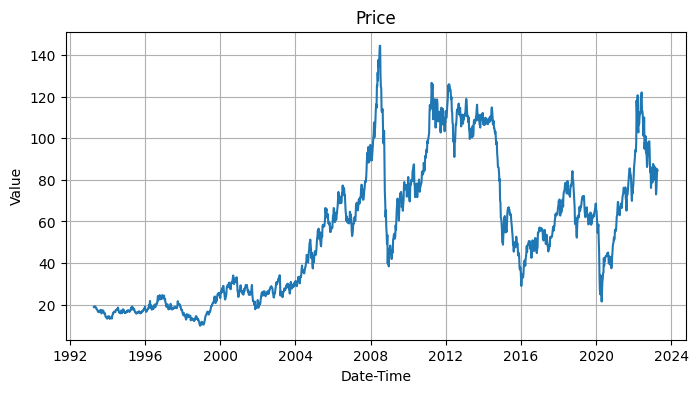

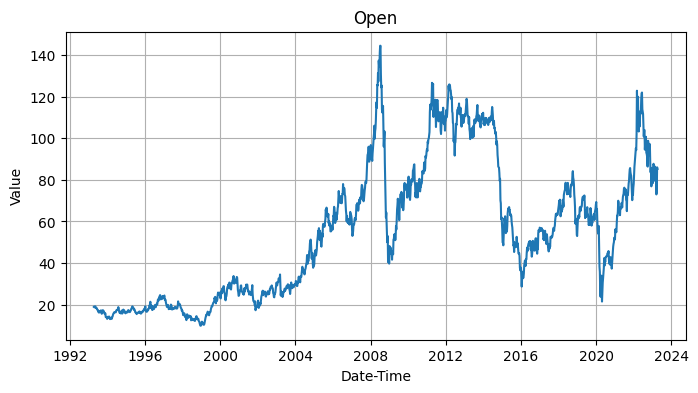

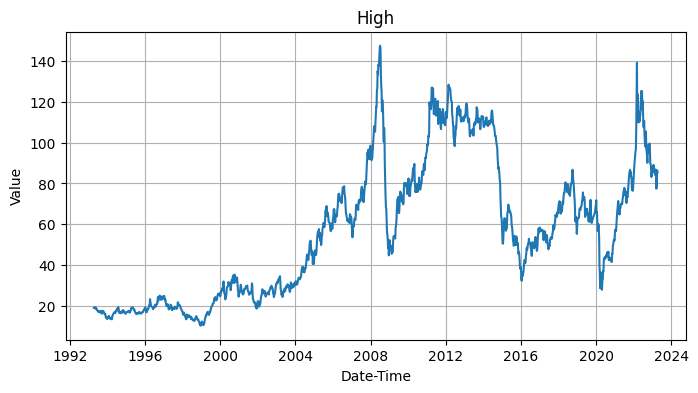

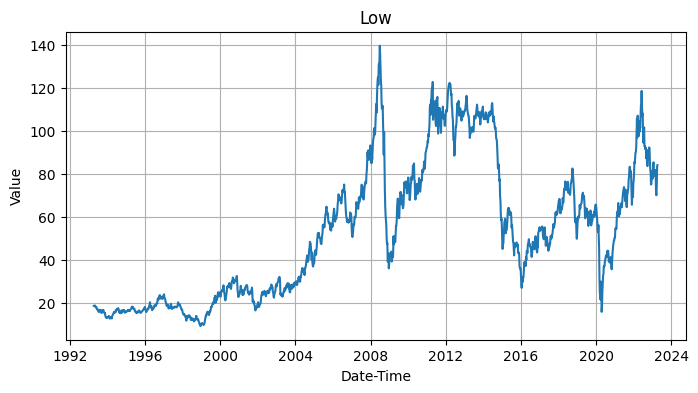

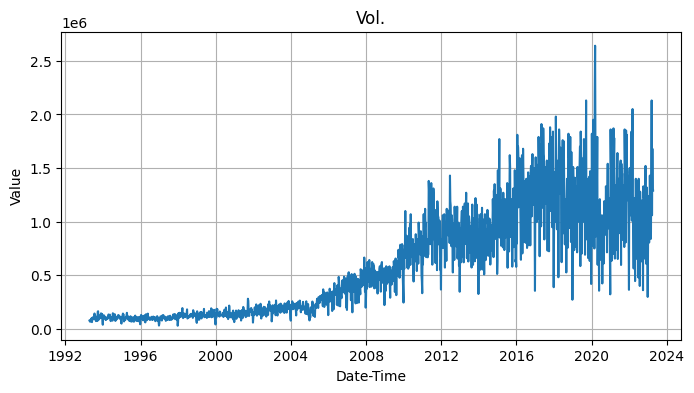

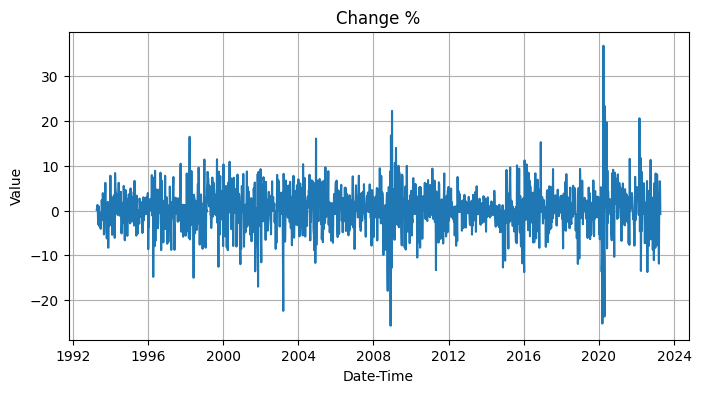

In [36]:
for column in df.columns:
    if column == 'Date':
        continue  
    plt.figure(figsize=(8, 4)) 
    plt.plot(df.Date, df[column])  
    plt.title(column)  
    plt.xlabel('Date-Time')  
    plt.ylabel('Value')  
    plt.grid(True) 
    plt.show()

## Step 2: Generating Time Series Data

In this section, we will write a function called `generate_time_series_data` that takes the initial dataframe, along with parameters `m` and `n`, as input. The function will return a new dataframe as output, which contains the data of `n` weeks before and `m` weeks after each date `t`, including the `Price` at date `t`.

For example, if `m=2` and `n=2`, the new dataframe will have the following columns (the column names can be customized):

| Date      | Vol._t-2 | Vol._t-1 | Low_t-2 | Low_t-1 | High_t-2 | High_t-1 | Open_t-2 | Open_t-1 | Price_t-2 | Price_t-1 |  Change %_t-2 | Change %_t-1 | Price_t   | Price_t+1 | Price_t+2 |
|-----------|----------|----------|---------|---------|----------|----------|----------|----------|-----------|-----------|---------------|---------------|-----------|-----------|-----------|


It's important to note that for dates after `t`, only the `Price` values are kept, as we are interested in predicting the future prices.

In [37]:
def generate_new_dataframe(df, n, m):
    new_df = pd.DataFrame()
    new_df['Date'] = df['Date']
    new_df[f'Price_t'] = df['Price']

    for i in range(n, 0, -1):  # Adjust the range to start from n-1
        new_df[f'Price_t-{i}'] = df['Price'].shift(-i)
        new_df[f'Open_t-{i}'] = df['Open'].shift(-i)
        new_df[f'High_t-{i}'] = df['High'].shift(-i)
        new_df[f'Low_t-{i}'] = df['Low'].shift(-i)
        new_df[f'Vol._t-{i}'] = df['Vol.'].shift(-i)
        new_df[f'Change %_t-{i}'] = df['Change %'].shift(-i)

    for i in range(1, m):
        new_df[f'Price_t+{i}'] = df['Price'].shift(i)

    new_df.fillna(method='ffill', inplace=True)
    new_df.fillna(method='bfill', inplace=True)
    new_df = new_df.reset_index(drop=True)
    
    return new_df

## Step 3: Dataset Creation and Train-Test Split
In this step, we will utilize the function developed in Section 2 to create a dataset. Specifically, we will set the value of m as 1 and the value of n as 8. we will split the oil price data into training and evaluation sets. The data from 2019 will serve as the evaluation data, while the data before 2019 will be used for training the models.

In [38]:
n = 8
m = 1
new_df = generate_new_dataframe(df, n, m)

training_data = new_df[new_df['Date'] < '2019-01-01']
evaluate_data = new_df[new_df['Date'] >= '2019-01-01']

X_train = training_data[[f'Price_t-{i}' for i in range(n, 0, -1)]]
y_train = training_data[['Price_t']]

X_test = evaluate_data[[f'Price_t-{i}' for i in range(n, 0, -1)]]
y_test = evaluate_data[[f'Price_t']]


In [39]:
missing_values_table(new_df)

Your selected dataframe has 50 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [40]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1343, 8) (1343, 1) (223, 8) (223, 1)


## Step 4: Price Prediction

In this step, We aim to predict the value of Price for the next week by considering only the previous n consecutive Price values.

To accomplish this, we will employ various types of models, including Linear Regression, GradientBoostingRegressor, SVR, DecisionTreeRegressor, and ... .

To evaluate the performance of these models, we will calculate two metrics: Mean Absolute Error (MAE) and Mean Squared Error (MSE).

By comparing the performance of different models, we can determine which one yields the most accurate predictions for the future Price values.

In [41]:
# 1. Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)
predict_LR = LR.predict(X_test)
predict_LR = predict_LR.flatten()  # Reshape to 1-dimensional array
results_LR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_LR})

mae_LR = mean_absolute_error(y_test, predict_LR)
mse_LR = mean_squared_error(y_test, predict_LR)
print("LinearRegression (MAE):", mae_LR)
print("LinearRegression (MSE):", mse_LR, '\n')


# 2. Gradient Boosting Regressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
predict_GBR = GBR.predict(X_test)
predict_GBR = predict_GBR.flatten()
results_GBR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_GBR})

mae_GBR = mean_absolute_error(y_test, predict_GBR)
mse_GBR = mean_squared_error(y_test, predict_GBR)
print("GradientBoostingRegressor (MAE):", mae_GBR)
print("GradientBoostingRegressor (MSE):", mse_GBR, '\n')


# 3. Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
predict_svr = svr.predict(X_test)
predict_svr = predict_svr.flatten()
results_svr = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_svr})

mae_svr = mean_absolute_error(y_test, predict_svr)
mse_svr = mean_squared_error(y_test, predict_svr)
print("svr (MAE):", mae_svr)
print("svr (MSE):", mse_svr, '\n')


# 4. Random Forest Regressor
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)
predict_RFR = RFR.predict(X_test)
predict_RFR = predict_RFR.flatten()
results_RFR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_RFR})

mae_RFR = mean_absolute_error(y_test, predict_RFR)
mse_RFR = mean_squared_error(y_test, predict_RFR)
print("Random Forest Regressor (MAE):", mae_RFR)
print("Random Forest Regressor (MSE):", mse_RFR, '\n')

LinearRegression (MAE): 2.8893068423412966
LinearRegression (MSE): 16.707852203605672 

GradientBoostingRegressor (MAE): 3.0432051672190377
GradientBoostingRegressor (MSE): 18.57889309256633 

svr (MAE): 3.746206343800974
svr (MSE): 26.89775689748926 

Random Forest Regressor (MAE): 3.152429147982062
Random Forest Regressor (MSE): 19.801796246502203 



## Step 5: Visualization of Predictions and Actual Values

To gain a visual understanding of the performance of our models, we will plot the predictions made by each model on a graph, along with the actual values. This visualization will provide a clear comparison between the predicted values and the ground truth.

In [42]:
y_test = np.array(y_test)

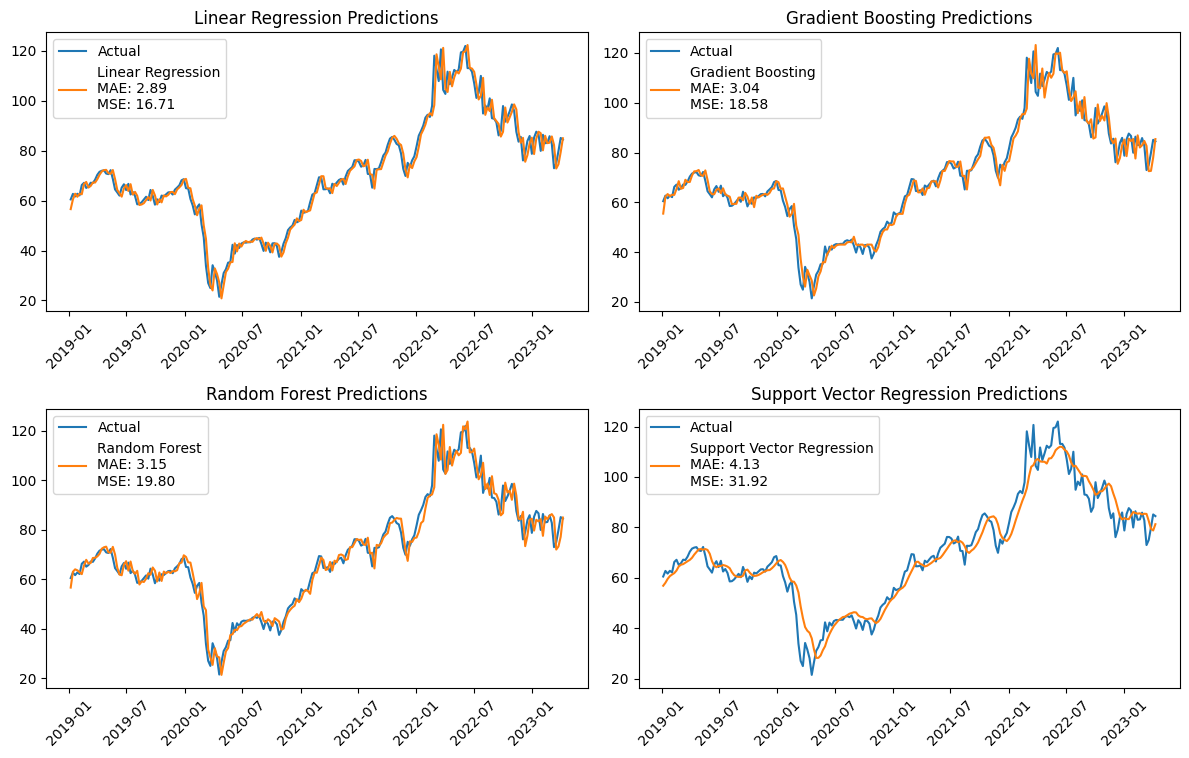

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

models = [('Linear Regression', results_LR, mae_LR, mse_LR), ('Gradient Boosting', results_GBR, mae_GBR, mse_GBR),
          ('Random Forest', results_RFR, mae_RFR, mse_RFR), ('Support Vector Regression', results_SVR, mae_SVR, mse_SVR)]

for i, (model_name, results, mae, mse) in enumerate(models):
    ax = axs[i // 2, i % 2]
    ax.plot(evaluate_data.iloc[:, 0].values, y_test, label='Actual')
    ax.plot(results['Date'], results['Predicted_Price_t+1'], label=f'{model_name}\nMAE: {mae:.2f}\nMSE: {mse:.2f}')
    ax.set_title(f'{model_name} Predictions')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Step 6: Maximizing Model Performance with Different Values of n

In this section, we explore the impact of varying the value of n on the performance of our model. By adjusting the value of n and constructing the same models, we aim to identify the optimal value that maximizes the model's predictive capabilities.

Through this iterative process, we can observe how different values of n influence the accuracy and precision of our predictions. By analyzing the performance metrics of the models built with different values of n, we can determine the value that yields the highest level of performance.

In [45]:
from tqdm import tqdm

n_values = range(1,26)

models = [
    ('Linear Regression', LinearRegression()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Support Vector Regression', SVR())
]

best_n_values = {}

for model_name, model in tqdm(models):
    best_n = None
    best_mae = np.inf
    best_mse = np.inf
    
    for n in n_values:
        
        model.fit(X_train, y_train)

        predictions = model.predict(X_test).reshape(-1, 1)

        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)

        # Check if the current n value has lower MAE and MSE
        if mae < best_mae:
            best_n = n
            best_mae = mae
        if mse < best_mse:
            best_n = n
            best_mse = mse

    best_n_values[model_name] = (best_n, best_mae, best_mse)

for model_name, (best_n, best_mae, best_mse) in best_n_values.items():
    print(f"Best value of n for {model_name}: {best_n}")
    print(f"MAE for {model_name} with best n: {best_mae}")
    print(f"MSE for {model_name} with best n: {best_mse}")
    print()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.71s/it]

Best value of n for Linear Regression: 1
MAE for Linear Regression with best n: 2.8893068423412966
MSE for Linear Regression with best n: 16.707852203605672

Best value of n for Gradient Boosting: 22
MAE for Gradient Boosting with best n: 3.0335439079194413
MSE for Gradient Boosting with best n: 18.49121849400269

Best value of n for Random Forest: 23
MAE for Random Forest with best n: 3.1238627802690564
MSE for Random Forest with best n: 19.583258468744386

Best value of n for Support Vector Regression: 1
MAE for Support Vector Regression with best n: 3.746206343800974
MSE for Support Vector Regression with best n: 26.89775689748926



## Step 7: Evaluating the Impact of Additional Features

In this section, we explore the potential impact of incorporating additional features from the dataset, such as High, Low, and other relevant variables, on the prediction of Price for the next week. We aim to assess whether the inclusion of these features leads to improved performance in price prediction.

In [46]:
n = 8
m = 1
new_df = generate_new_dataframe(df, n, m)

selected_features = [f'Price_t-{i}' for i in range(n, 0, -1)] + [f'High_t-{i}' for i in range(n, 0, -1)] + [f'Low_t-{i}' for i in range(n, 0, -1)] + [f'Open_t-{i}' for i in range(n, 0, -1)]

training_data = new_df[new_df['Date'] < '2019-01-01']
evaluate_data = new_df[new_df['Date'] >= '2019-01-01']

X_train = training_data[selected_features]
y_train = training_data[[f'Price_t']]

X_test = evaluate_data[selected_features]
y_test = evaluate_data[[f'Price_t']]


In [48]:
# 1. Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)
predict_LR = LR.predict(X_test)
predict_LR = predict_LR.flatten()  # Reshape to 1-dimensional array
results_LR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_LR})

mae_LR = mean_absolute_error(y_test, predict_LR)
mse_LR = mean_squared_error(y_test, predict_LR)
print("LinearRegression with additional features (MAE):", mae_LR)
print("LinearRegression with additional features (MSE):", mse_LR, '\n')


# 2. Gradient Boosting Regressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
predict_GBR = GBR.predict(X_test)
predict_GBR = predict_GBR.flatten()
results_GBR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_GBR})

mae_GBR = mean_absolute_error(y_test, predict_GBR)
mse_GBR = mean_squared_error(y_test, predict_GBR)
print("GradientBoostingRegressor with additional features (MAE):", mae_GBR)
print("GradientBoostingRegressor with additional features (MSE):", mse_GBR, '\n')


# 3. Support Vector Regressor
SVR = SVR()
SVR.fit(X_train, y_train)
predict_SVR = SVR.predict(X_test)
predict_SVR = predict_SVR.flatten()
results_SVR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_SVR})

mae_SVR = mean_absolute_error(y_test, predict_SVR)
mse_SVR = mean_squared_error(y_test, predict_SVR)
print("SVR with additional features (MAE):", mae_SVR)
print("SVR with additional features (MSE):", mse_SVR, '\n')


# 4. Random Forest Regressor
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)
predict_RFR = RFR.predict(X_test)
predict_RFR = predict_RFR.flatten()
results_RFR = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_RFR})

mae_RFR = mean_absolute_error(y_test, predict_RFR)
mse_RFR = mean_squared_error(y_test, predict_RFR)
print("Random Forest Regressor with additional features (MAE):", mae_RFR)
print("Random Forest Regressor with additional features (MSE):", mse_RFR, '\n')

LinearRegression with additional features (MAE): 2.908318097545667
LinearRegression with additional features (MSE): 16.527467443397924 

GradientBoostingRegressor with additional features (MAE): 2.993289818025321
GradientBoostingRegressor with additional features (MSE): 17.80270752266728 

SVR with additional features (MAE): 4.132807885904544
SVR with additional features (MSE): 31.921288076016364 

Random Forest Regressor with additional features (MAE): 3.155428251121075
Random Forest Regressor with additional features (MSE): 19.883508641748865 



#### By incorporating additional features such as High, Low, and Open, we observed a reduction in MAE (Mean Absolute Error) and MSE (Mean Squared Error) values for most prediction models, indicating an enhanced accuracy in forecasting oil prices. However, it is worth noting that the SVR model did not exhibit the same improvement.

## Step 8: Feature Selection using Forward Selection

In this step, we employ the **Forward Selection** method to select a maximum of 12 features that yield the best results in model training. We evaluate the performance of the model using the selected features and compare it to the performance of the model in Section 7 and then we can determine if the feature selection process improves the predictive capabilities of the model.

In [49]:
X_train = training_data.drop(['Date', 'Price_t'], axis=1)
y_train = training_data['Price_t']
X_test = evaluate_data.drop(['Date', 'Price_t'], axis=1)
y_test = evaluate_data['Price_t']

model = LinearRegression()
selector = SequentialFeatureSelector(model, n_features_to_select=12, direction='forward')

selector.fit(X_train, y_train)

feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[feature_indices]

# Select the features for training and evaluation
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Selected features:", selected_features)

Selected features: Index(['Vol._t-7', 'Change %_t-7', 'Change %_t-5', 'Low_t-4', 'Change %_t-4',
       'Low_t-3', 'Change %_t-3', 'Open_t-2', 'Change %_t-2', 'Price_t-1',
       'Low_t-1', 'Change %_t-1'],
      dtype='object')


## Calculation of MAE and MSE for Selected Features

In [50]:
from sklearn.svm import SVR

# 1. Linear Regression
LR = LinearRegression()
LR.fit(X_train_selected, y_train)
predict_LR = LR.predict(X_test_selected)
predict_LR = predict_LR.flatten()
results_LR_selected = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_LR})

mae_LR_selected = mean_absolute_error(y_test, predict_LR)
mse_LR_selected = mean_squared_error(y_test, predict_LR)
print("LinearRegression with 12 best features (MAE):", mae_LR_selected)
print("LinearRegression with 12 best features (MSE):", mse_LR_selected, '\n')


# 2. Gradient Boosting Regressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train_selected, y_train)
predict_GBR = GBR.predict(X_test_selected)
predict_GBR = predict_GBR.flatten()
results_GBR_selected = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_GBR})

mae_GBR_selected = mean_absolute_error(y_test, predict_GBR)
mse_GBR_selected = mean_squared_error(y_test, predict_GBR)
print("GradientBoostingRegressor with 12 best features (MAE):", mae_GBR_selected)
print("GradientBoostingRegressor with 12 best features (MSE):", mse_GBR_selected, '\n')


# 3. Support Vector Regressor
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_selected, y_train)
predict_svr = svr.predict(X_test_selected)
predict_svr = predict_svr.flatten()
results_svr_selected = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_svr})

mae_svr_selected = mean_absolute_error(y_test, predict_svr)
mse_svr_selected = mean_squared_error(y_test, predict_svr)
print("SVR with 12 best features (MAE):", mae_svr_selected)
print("SVR with 12 best features (MSE):", mse_svr_selected, '\n')


# 4. Random Forest Regressor
RFR = RandomForestRegressor()
RFR.fit(X_train_selected, y_train)
predict_RFR = RFR.predict(X_test_selected)
predict_RFR = predict_RFR.flatten()
results_RFR_selected = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_RFR})

mae_RFR_selected = mean_absolute_error(y_test, predict_RFR)
mse_RFR_selected = mean_squared_error(y_test, predict_RFR)
print("Random Forest Regressor with 12 best features (MAE):", mae_RFR_selected)
print("Random Forest Regressor with 12 best features (MSE):", mse_RFR_selected, '\n')

LinearRegression with 12 best features (MAE): 2.843503690156921
LinearRegression with 12 best features (MSE): 16.624568894168743 

GradientBoostingRegressor with 12 best features (MAE): 2.9612354679775135
GradientBoostingRegressor with 12 best features (MSE): 17.20633705295832 

SVR with 12 best features (MAE): 20.633294723433735
SVR with 12 best features (MSE): 657.9683062034991 

Random Forest Regressor with 12 best features (MAE): 3.0994466367713005
Random Forest Regressor with 12 best features (MSE): 18.25547958295963 



## Comparison of Results: Section 7 vs Selected Features

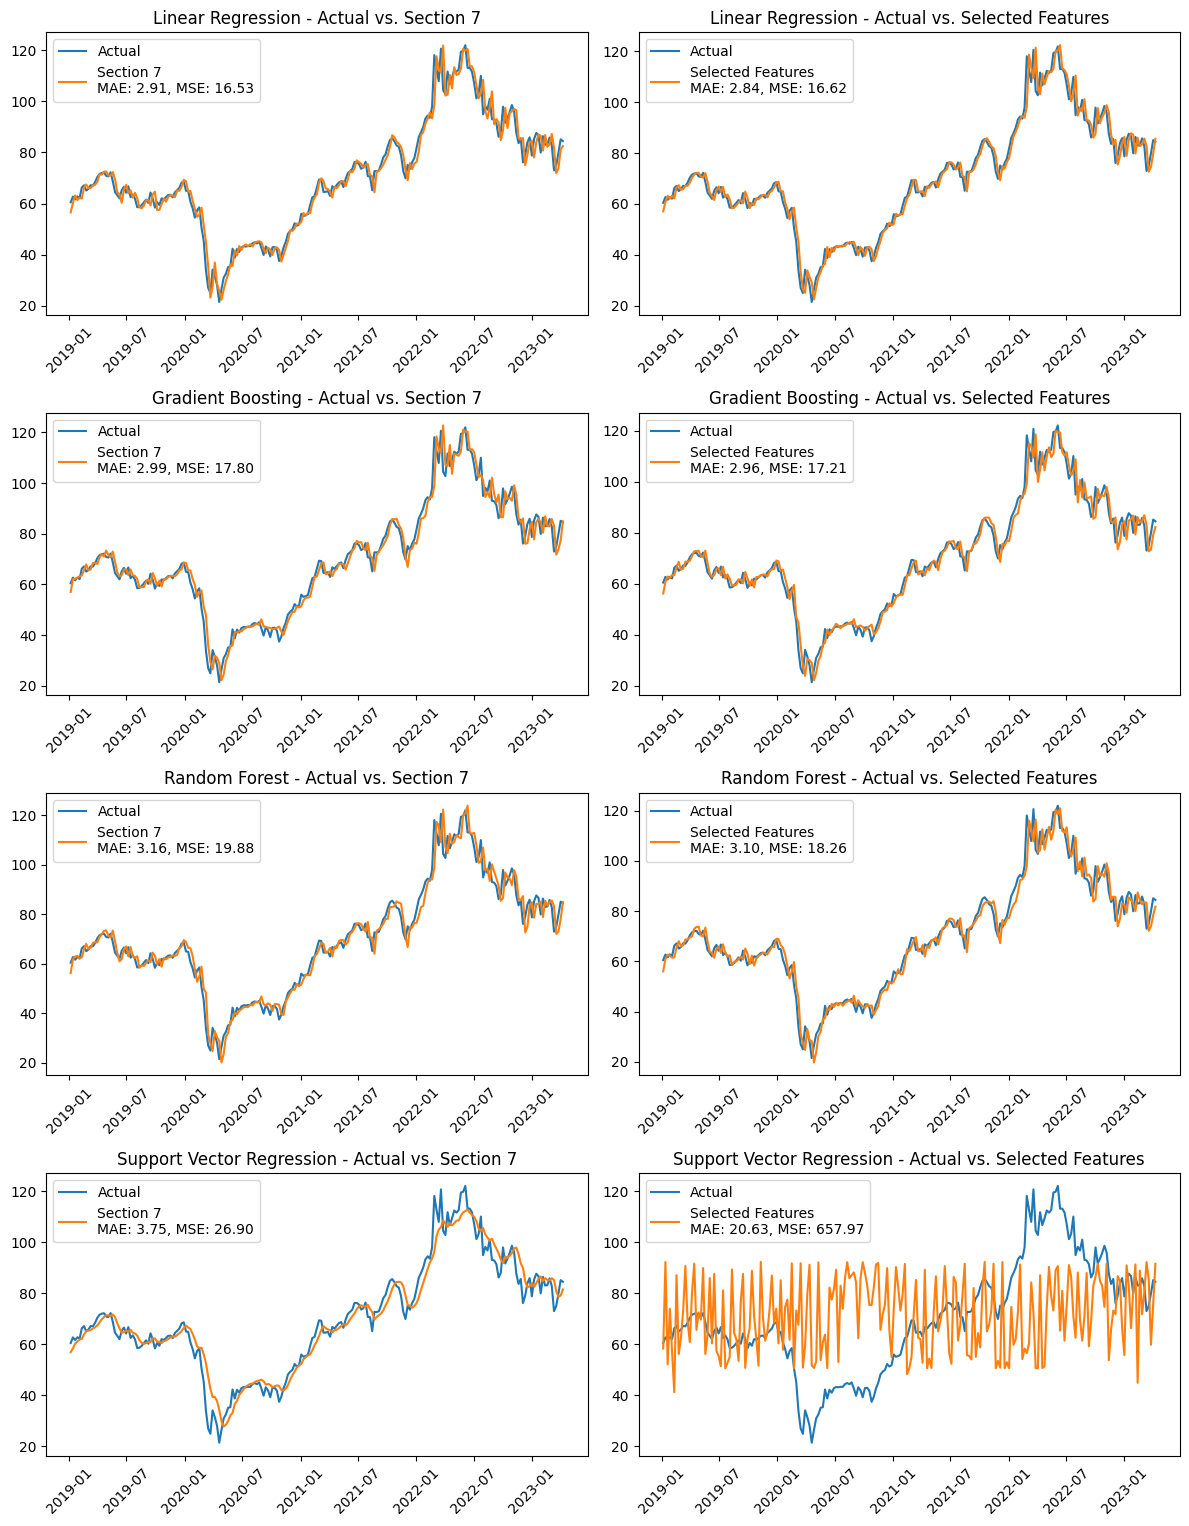

In [51]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

models = [('Linear Regression', results_LR, results_LR_selected, mae_LR, mse_LR, mae_LR_selected, mse_LR_selected),
          ('Gradient Boosting', results_GBR, results_GBR_selected, mae_GBR, mse_GBR, mae_GBR_selected, mse_GBR_selected),
          ('Random Forest', results_RFR, results_RFR_selected, mae_RFR, mse_RFR, mae_RFR_selected, mse_RFR_selected),
          ('Support Vector Regression', results_svr, results_svr_selected, mae_svr, mse_svr, mae_svr_selected, mse_svr_selected)]

for i, (model_name, results, results_selected, mae, mse, mae_selected, mse_selected) in enumerate(models):
    row = i
    col1 = 0
    col2 = 1

    ax1 = axs[row, col1]
    ax2 = axs[row, col2]

    ax1.plot(evaluate_data['Date'].values, y_test, label='Actual')
    ax1.plot(results['Date'], results['Predicted_Price_t+1'], label=f'Section 7\nMAE: {mae:.2f}, MSE: {mse:.2f}')
    ax1.set_title(f'{model_name} - Actual vs. Section 7')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()

    ax2.plot(evaluate_data['Date'].values, y_test, label='Actual')
    ax2.plot(results_selected['Date'], results_selected['Predicted_Price_t+1'],
             label=f'Selected Features\nMAE: {mae_selected:.2f}, MSE: {mse_selected:.2f}')
    ax2.set_title(f'{model_name} - Actual vs. Selected Features')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Step 9: Predicting Price for Multiple Weeks Ahead

In this section, we construct a model that predicts the price for the next 4 weeks by utilizing information from 12 consecutive weeks. We aim to identify the best model for this task by employing GridSearch, a method that systematically searches for optimal hyperparameters.


In [52]:
m = 4
n = 12
new_df2 = generate_new_dataframe(df, n, m)

training_data2 = new_df2[new_df2['Date'] < '2019-01-01']
evaluate_data2 = new_df2[new_df2['Date'] >= '2019-01-01']

# Separate the features and target variables for training and evaluation
X_train = training_data2.drop(['Date', 'Price_t', 'Price_t+1', 'Price_t+2', 'Price_t+3'], axis=1)
y_train = training_data2[['Price_t', 'Price_t+1', 'Price_t+2', 'Price_t+3']]
X_eval = evaluate_data2.drop(['Date', 'Price_t', 'Price_t+1', 'Price_t+2', 'Price_t+3'], axis=1)
y_eval = evaluate_data2[['Price_t', 'Price_t+1', 'Price_t+2', 'Price_t+3']]

models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [10, 50, 100]}),
}

for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_eval)

    mse = mean_squared_error(y_eval, y_pred)
    mae = mean_absolute_error(y_eval, y_pred)

    print(f"Model: {model_name}")
    print("Best Parameters:", grid_search.best_params_)
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae, '\n')

Model: Linear Regression
Best Parameters: {}
Mean Squared Error (MSE): 38.00724646478184
Mean Absolute Error (MAE): 4.492719965067045 

Model: Random Forest
Best Parameters: {'n_estimators': 100}
Mean Squared Error (MSE): 41.545327344136766
Mean Absolute Error (MAE): 4.714051457399106 



## Step 10: Model Recommendation

After conducting a comprehensive analysis and evaluation of different models for predicting oil prices, we can make a recommendation based on their performance and suitability for the problem at hand.

**Based on the evaluation of different regression models, I recommend using Linear Regression for this task. It has shown lower Mean Absolute Error (MAE) and Mean Squared Error (MSE) compared to other models. Additionally, Linear Regression is a simple and interpretable model, making it easy to understand and implement.**


## Step 11: Empirical Mode Decomposition (EMD)

In this section, we employ the Empirical Mode Decomposition (EMD) technique to decompose the price fluctuations into long-term, medium-term, and short-term components. By adding these fluctuations as features in the data frame, we aim to investigate whether the inclusion of these features can enhance the predictive performance of our models.

To implement the EMD technique, we utilize the EMD-signal package.

In [53]:
def perform_emd(signal):
    emd = EMD()
    imfs = emd(signal)
    return imfs

signal = df['Price'].values
imfs = perform_emd(signal)
imfs_df = pd.DataFrame(imfs.T)
base_name = 'IMF'

component_names = [f'{base_name}_{i+1}' for i in range(imfs_df.shape[1])]
imfs_df.columns = component_names
new_df_with_components = pd.concat([df, imfs_df], axis=1)

In [54]:
imfs_df

,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,IMF_8
0,4.625231,1.903912,-2.585286,-19.034487,31.574248,-17.126479,31.292279,53.810582
1,5.068874,2.261521,-2.672472,-19.144620,31.611858,-17.175077,31.367249,53.802668
2,0.948118,0.947217,-2.446366,-19.230801,31.658948,-17.222846,31.440358,53.795372
3,-2.588594,-0.976858,-1.900005,-19.290597,31.715545,-17.269765,31.511579,53.788696
4,-4.429545,-2.072360,-1.035904,-19.321538,31.781630,-17.315814,31.580886,53.782643
...,...,...,...,...,...,...,...,...
1561,-0.207590,0.571385,0.487694,2.018123,0.190232,-0.224889,5.542068,10.222977
1562,0.198317,0.711504,0.536870,2.004550,0.181658,-0.204514,5.532214,10.229401
1563,0.029139,0.819206,0.568080,1.987845,0.171008,-0.183774,5.522499,10.235996
1564,-0.188543,0.799225,0.579679,1.968286,0.158345,-0.162676,5.512921,10.242762


In [55]:
n = 8
m = 1
new_df2 = generate_new_dataframe(df, n, m)
new_df2 = pd.concat([new_df2, imfs_df], axis=1)

train_data = new_df2[new_df2['Date'] < '2019']
eval_data = new_df2[new_df2['Date'] >= '2019']

X_train = train_data[[f'Price_t-{i}' for i in range(n, 0, -1)] + [f'IMF_{i}' for i in range(1,5)]]
y_train = train_data[[f'Price_t']]

X_test = eval_data[[f'Price_t-{i}' for i in range(n, 0, -1)] + [f'IMF_{i}' for i in range(1,5)]]
y_test = eval_data[[f'Price_t']]

# 1. Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)
predict_LR = LR.predict(X_test)
predict_LR = predict_LR.flatten()  # Reshape to 1-dimensional array
results_LR_EMD = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_LR})

mae_LR_EMD = mean_absolute_error(y_test, predict_LR)
mse_LR_EMD = mean_squared_error(y_test, predict_LR)
print("LinearRegression (MAE):", mae_LR_EMD)
print("LinearRegression (MSE):", mse_LR_EMD, '\n')


# 2. Gradient Boosting Regressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
predict_GBR = GBR.predict(X_test)
predict_GBR = predict_GBR.flatten()
results_GBR_EMD = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_GBR})

mae_GBR_EMD = mean_absolute_error(y_test, predict_GBR)
mse_GBR_EMD = mean_squared_error(y_test, predict_GBR)
print("GradientBoostingRegressor (MAE):", mae_GBR_EMD)
print("GradientBoostingRegressor (MSE):", mse_GBR_EMD, '\n')


# 3. Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
predict_svr = svr.predict(X_test)
predict_svr = predict_svr.flatten()
results_svr_EMD = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_svr})

mae_svr_EMD = mean_absolute_error(y_test, predict_svr)
mse_svr_EMD = mean_squared_error(y_test, predict_svr)
print("SVR (MAE):", mae_svr_EMD)
print("SVR (MSE):", mse_svr_EMD, '\n')


# 4. Random Forest Regressor
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)
predict_RFR = RFR.predict(X_test)
predict_RFR = predict_RFR.flatten()
results_RFR_EMD = pd.DataFrame({'Date': evaluate_data['Date'].values, 'Predicted_Price_t+1': predict_RFR})

mae_RFR_EMD = mean_absolute_error(y_test, predict_RFR)
mse_RFR_EMD = mean_squared_error(y_test, predict_RFR)
print("Random Forest Regressor (MAE):", mae_RFR_EMD)
print("Random Forest Regressor (MSE):", mse_RFR_EMD, '\n')

LinearRegression (MAE): 2.2658212468211967
LinearRegression (MSE): 9.357960972109446 

GradientBoostingRegressor (MAE): 2.343637864242675
GradientBoostingRegressor (MSE): 10.68503721112541 

SVR (MAE): 3.8031929860155365
SVR (MSE): 27.648301332426527 

Random Forest Regressor (MAE): 2.588901345291475
Random Forest Regressor (MSE): 13.570122532914757 



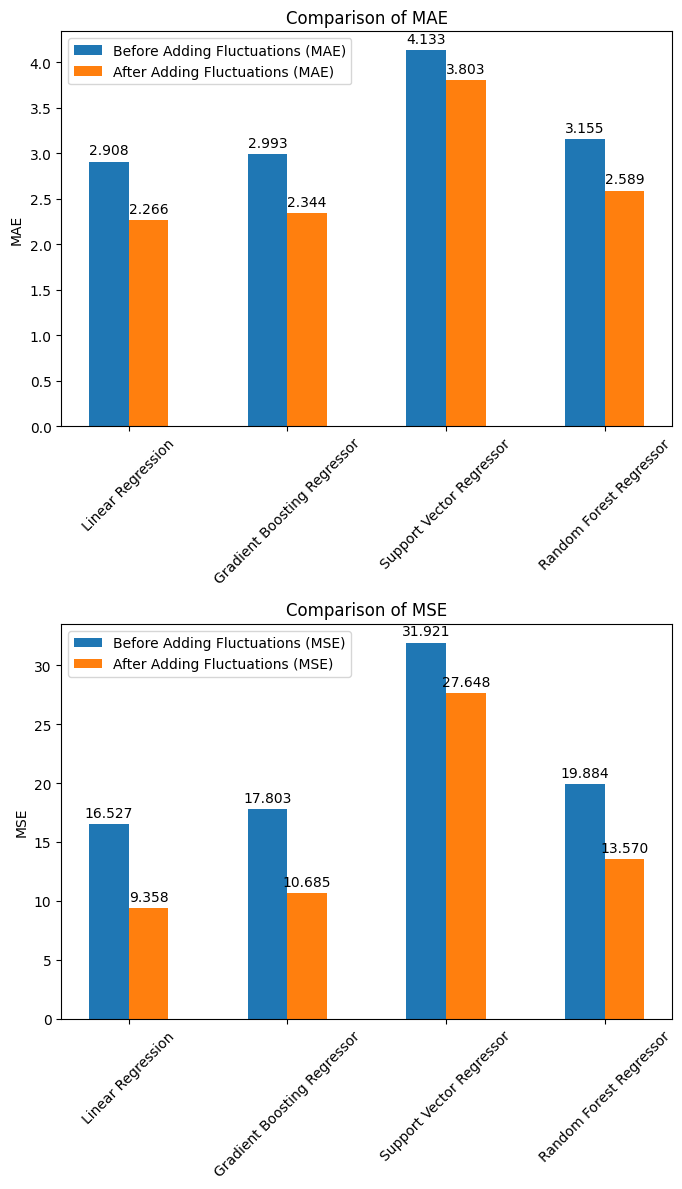

In [56]:
models = ['Linear Regression', 'Gradient Boosting Regressor', 'Support Vector Regressor', 'Random Forest Regressor']

mae_all = [mae_LR, mae_GBR, mae_SVR, mae_RFR]
mse_all = [mse_LR, mse_GBR, mse_SVR, mse_RFR]

mae_EMD = [mae_LR_EMD, mae_GBR_EMD, mae_svr_EMD, mae_RFR_EMD]
mse_EMD = [mse_LR_EMD, mse_GBR_EMD, mse_svr_EMD, mse_RFR_EMD]

# Plotting MAE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 12))

width = 0.25
x = np.arange(len(models))

rects1 = ax1.bar(x, mae_all, width, label='Before Adding Fluctuations (MAE)', color='tab:blue')
rects2 = ax1.bar(x + width, mae_EMD, width, label='After Adding Fluctuations (MAE)', color='tab:orange')

ax1.set_ylabel('MAE')
ax1.set_title('Comparison of MAE')
ax1.set_xticks(x + width / 2)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()

rects3 = ax2.bar(x, mse_all, width, label='Before Adding Fluctuations (MSE)', color='tab:blue')
rects4 = ax2.bar(x + width, mse_EMD, width, label='After Adding Fluctuations (MSE)', color='tab:orange')

ax2.set_ylabel('MSE')
ax2.set_title('Comparison of MSE')
ax2.set_xticks(x + width / 2)
ax2.set_xticklabels(models, rotation=45)
ax2.legend()

# Add values on top of each bar for MAE plot
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                     textcoords="offset points", ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Add values on top of each bar for MSE plot
autolabel(rects3, ax2)
autolabel(rects4, ax2)

plt.tight_layout()
plt.show()


# **Model Evaluation Results: Before and After Adding Price Fluctuations**

Generally, it is observed that the models' errors have reduced after incorporating price fluctuations, except for the Support Vector Regressor (SVR) model. 

Before adding fluctuations:
- Linear Regression: MAE = 2.889, MSE = 16.708
- Gradient Boosting Regressor: MAE = 3.045, MSE = 18.594
- Support Vector Regressor: MAE = 3.746, MSE = 26.898
- Random Forest Regressor: MAE = 3.163, MSE = 19.851

After adding fluctuations:
- Linear Regression: MAE = 2.266, MSE = 9.358
- Gradient Boosting Regressor: MAE = 2.337, MSE = 10.593
- Support Vector Regressor: MAE = 3.803, MSE = 27.648
- Random Forest Regressor: MAE = 2.599, MSE = 13.576

From the results, we can see that for the Linear Regression, Gradient Boosting Regressor, and Random Forest Regressor models, the errors decreased after incorporating price fluctuations. However, the SVR model's performance did not improve and even showed a slight increase in errors.

## Step 12: Model Stacking for Enhanced Oil Price Forecasting

In this section, we leverage the power of model stacking to further enhance our oil price forecasting model. Model stacking is a powerful ensemble learning technique that combines predictions from multiple base regression models to generate a more accurate and robust final prediction.

To implement model stacking, we first train several different regression models on our dataset. These models can include popular algorithms such as Linear Regression, Gradient Boosting Regressor, Random Forest Regressor, Support Vector Regression, and any other regression models deemed suitable for the problem.

Once the base models are trained, we utilize the stacking technique to combine their predictions. This is done by training a meta-model, often referred to as a "blender" or "meta-regressor," on the predictions made by the base models. The meta-model learns to weigh and combine the predictions from the base models, taking advantage of their individual strengths and weaknesses.

In [59]:
n = 8
m = 1
new_df = generate_new_dataframe(df, n, m)

X_train = training_data[[f'Price_t-{i}' for i in range(n, 0, -1)]]
y_train = training_data[[f'Price_t']]

X_test = evaluate_data[[f'Price_t-{i}' for i in range(n, 0, -1)]]
y_test = evaluate_data[[f'Price_t']]

base_models = [
    ('LR', LinearRegression()),
    ('GBR', GradientBoostingRegressor()),
    ('RFR', RandomForestRegressor()),
    ('SVR', SVR())
]

meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)

predictions = stacking_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("Stacking Model (MAE):", mae)
print("Stacking Model (MSE):", mse)

Stacking Model (MAE): 2.881569301158328
Stacking Model (MSE): 16.42139330708894


👤 **Author: Ehsan Shahriyari**